In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv


**Project's Description**
This is a classification project for determining whether a person has a heart disease or not
based on information such as: age, max heart rate, cholesterol levels etc...

The project is divided into 2 parts other than the preliminary ones (preprocessing and basic
data analysis).

**Part 1** - Checking non linear models, described in more detail down below.

**Part 2** - Checking neural network, described in more detail down below.

In [2]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

2025-10-15 10:54:13.296612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760525653.564238      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760525653.640195      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# To make experiments reproducible

os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'


**fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved 10/10/2025 from https://www.kaggle.com/fedesoriano/heart-failure-prediction.**


The data set was created as a mix of different datasets from different areas(important), the 
distributions are: 

Cleveland: 303 observations

Hungarian: 294 observations

Switzerland: 123 observations

Long Beach VA: 200 observations

Stalog (Heart) Data Set: 270 observations

Later on, it's explained how the diagnosis and distributions relate to the setting in which the
samples are collected, making this information important for further analysis.

In [4]:
path = "/kaggle/input/heart-failure-prediction/heart.csv"

df = pd.read_csv(path)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.isna().sum()

# No holes

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
df.describe()

# We can see RestingBP as 0 here, as well as cholesterol, requires further investigation

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [7]:
print(df[df['RestingBP'] == 0])

# Removing the patient, seems to be an error, just one sample

print('-----')
print(df[df['Cholesterol'] == 0])

# In the case of cholesterol, replace 0 with the mean because of quantity of samples

     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
449   55   M           NAP          0            0          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
449    155              N      1.5     Flat             1  
-----
     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
293   65   M           ASY        115            0          0     Normal   
294   32   M            TA         95            0          1     Normal   
295   61   M           ASY        105            0          1     Normal   
296   50   M           ASY        145            0          1     Normal   
297   57   M           ASY        110            0          1         ST   
..   ...  ..           ...        ...          ...        ...        ...   
514   43   M           ASY        122            0          0     Normal   
515   63   M           NAP        130            0          1         ST   
518   48   M           NAP        102

In [8]:
df.drop(449, inplace=True)

In [9]:
cholesterol_median = df['Cholesterol'][df['Cholesterol'] != 0].median()
df['Cholesterol'] = df['Cholesterol'].replace(0, cholesterol_median)
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,53.509269,132.540894,243.211559,0.233370,136.789531,0.886696,0.552890
std,9.437636,17.999749,53.430044,0.423206,25.467129,1.066960,0.497466
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,237.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [10]:
df.duplicated().sum()

# No duplicates

0

In [11]:
num_columns = df.select_dtypes(include='number').columns.values
cat_columns = df.select_dtypes(include='object').columns.values

print(f'numerical columns: {num_columns}')
print(f'categorical columns: {cat_columns}')

numerical columns: ['Age' 'RestingBP' 'Cholesterol' 'FastingBS' 'MaxHR' 'Oldpeak'
 'HeartDisease']
categorical columns: ['Sex' 'ChestPainType' 'RestingECG' 'ExerciseAngina' 'ST_Slope']


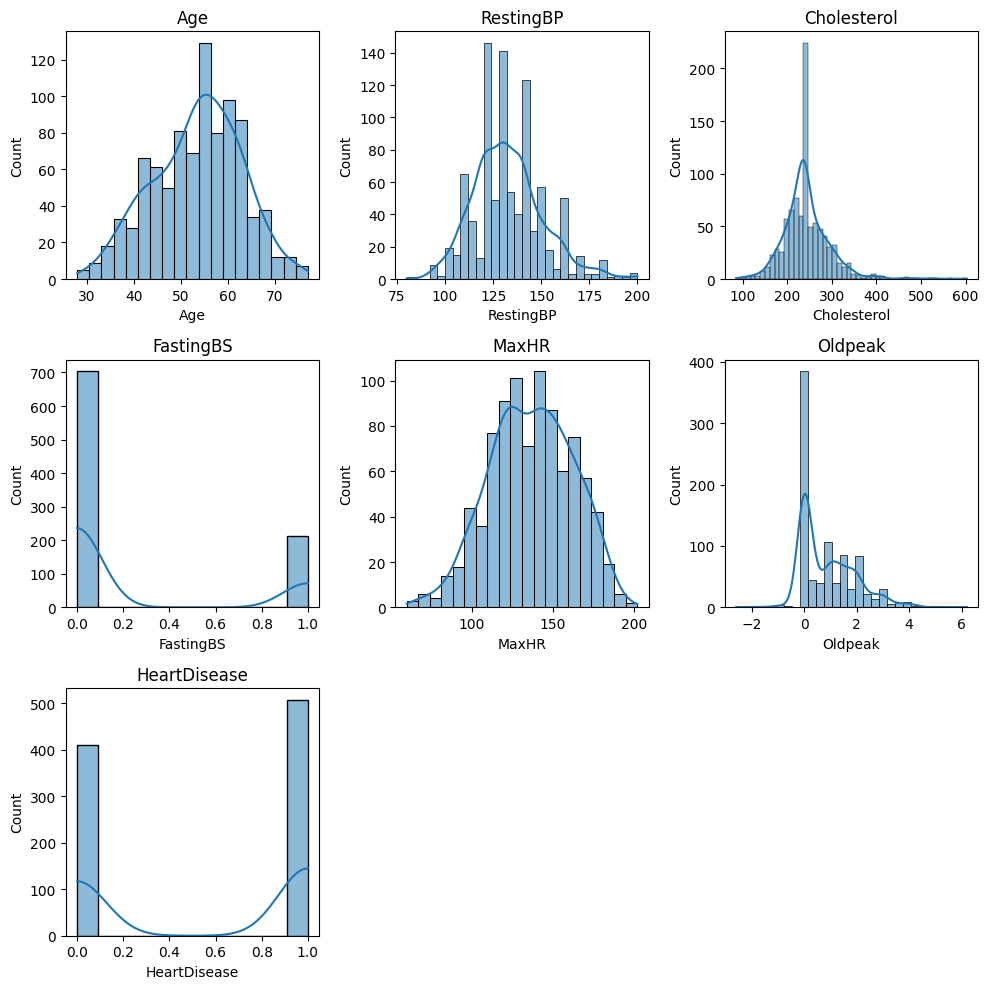

In [12]:
# numerical values

# Distributions - numerical columns
fig, axes = plt.subplots(3,3, figsize=(10,10))
axes = axes.flatten()

for i in range(len(num_columns)):
    sns.histplot(df, x=num_columns[i], ax=axes[i], kde=True)
    axes[i].set_title(num_columns[i])
    
for j in range(i+1, 9):
    plt.delaxes(axes[j])

plt.tight_layout()
plt.show()

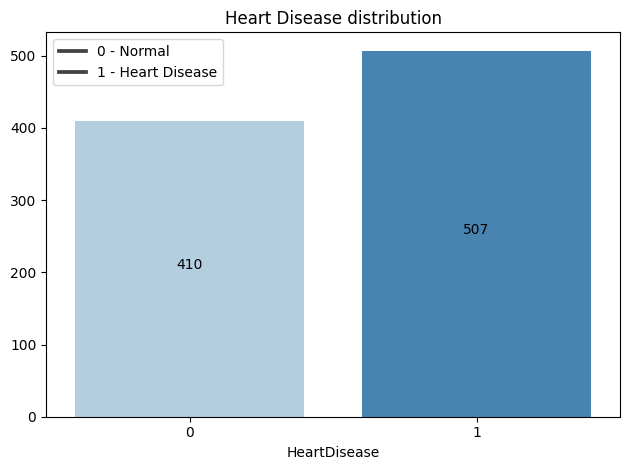

In [13]:
# Heart Disease distribution - Class distribution

heart_disease_count = df['HeartDisease'].value_counts()
legend = ['0 - Normal', '1 - Heart Disease']

sns.barplot(x=heart_disease_count.index, y=heart_disease_count.values, palette='Blues')
plt.title('Heart Disease distribution')
plt.legend(legend)

for i in range(len(heart_disease_count)):
    plt.text(heart_disease_count.index[i], heart_disease_count.values[i] // 2, s=str(heart_disease_count.values[i]), horizontalalignment='center')

plt.tight_layout()
plt.show()

# Misbalance between the datasets, since it's not too misbalanced with a ratio of 1.23, we can ignore.
# in case needs to be treated, SMOTE, NearMiss (explained at the end), inverse weights are all options

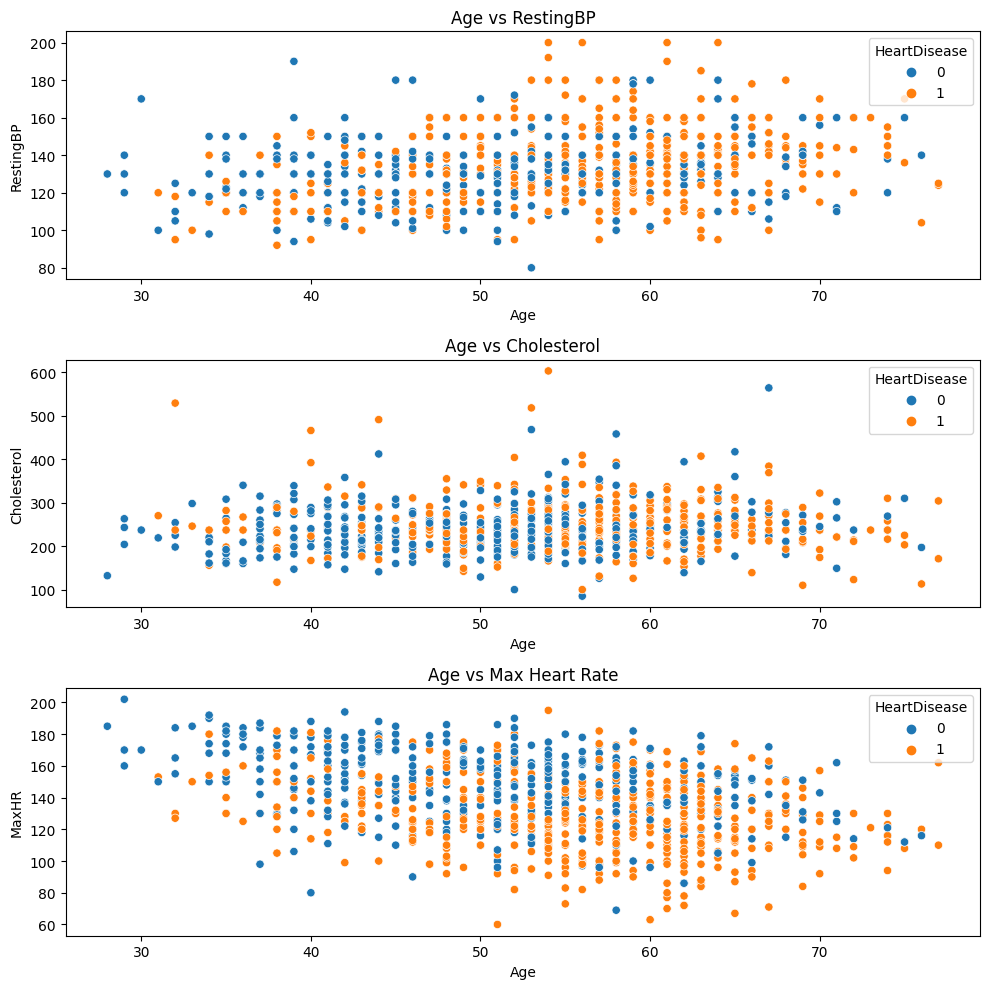

In [14]:
# Different relationships I wanted to visualize

# age vs resting bp   ---   age vs cholesterol   ---   age vs max heart rate

fig, axes = plt.subplots(3,1, figsize=(10,10))

# Resting heart rate seems to be a little bit higher on average with heart disease, hard to draw
# conclusions
sns.scatterplot(data=df, x='Age', y='RestingBP', ax=axes[0], hue='HeartDisease')
axes[0].set_title('Age vs RestingBP')

# Hard to draw conclusions here since we changed 0 cholesterol cases to the median
sns.scatterplot(data=df, x='Age', y='Cholesterol', ax=axes[1], hue='HeartDisease')
axes[1].set_title('Age vs Cholesterol')

# we can see that in general, the lower the age, the higher the max heart rate
sns.scatterplot(data=df, x='Age', y='MaxHR', ax=axes[2], hue='HeartDisease')
axes[2].set_title('Age vs Max Heart Rate')

plt.tight_layout()
plt.show()

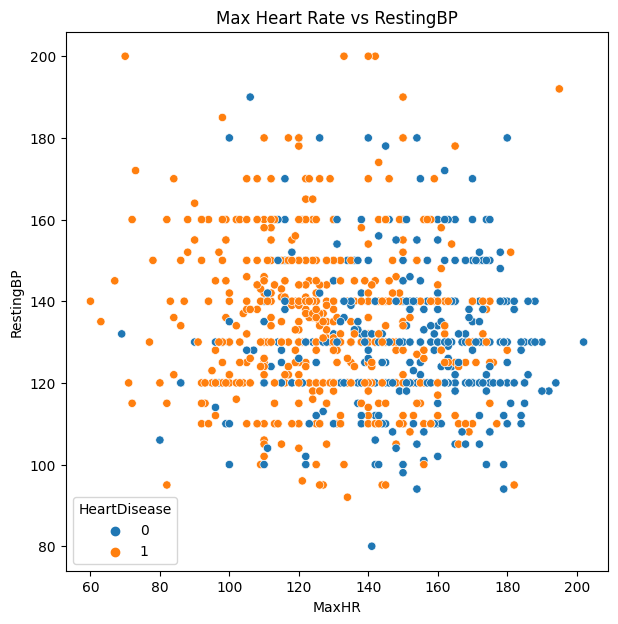

In [15]:
# Max heart rate vs resting bp

plt.figure(figsize=(7,7))
sns.scatterplot(data=df, x='MaxHR', y='RestingBP',hue='HeartDisease')
plt.title('Max Heart Rate vs RestingBP')
plt.show()

# Seems like people with lower max heart rate have heart disease, but maybe they have lower max heart
# rate because they have a heart disease(train less, more careful are possibilis), hard to draw 
# definitive conclusions from it. Resting bp seems mixed and doesn't show obvious connections.

# In any case, it does seem it's an important factor in determining heart problems, a correlation 
# matrix should help

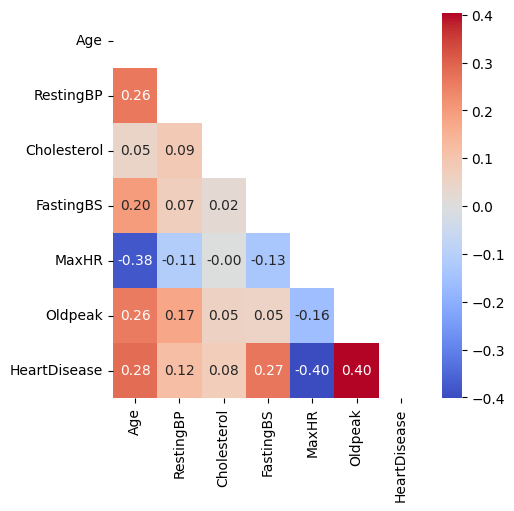

In [16]:
m = df[num_columns]
m = m.corr()
mask = np.triu(np.ones_like(m, dtype=bool))
plt.figure(figsize=(5,5))
sns.heatmap(m, annot=True, cmap='coolwarm',fmt='.2f', mask=mask)
plt.show()

# There is a positive correlation between heart disease to higher age, higher oldPeak and higher
# fasting bs

# There is a very high negative correlation between a higher max heart rate to having heart disease

# On a sidenot, we are seeing a high negative correlation between age and maxhr, and a decent positive
# correlation between oldpek and resting bp. Age just makes things worse in general in regards
# to heart disease (Before drawing conclusions though, a look at where the samples were taken from
# should be an important factor)

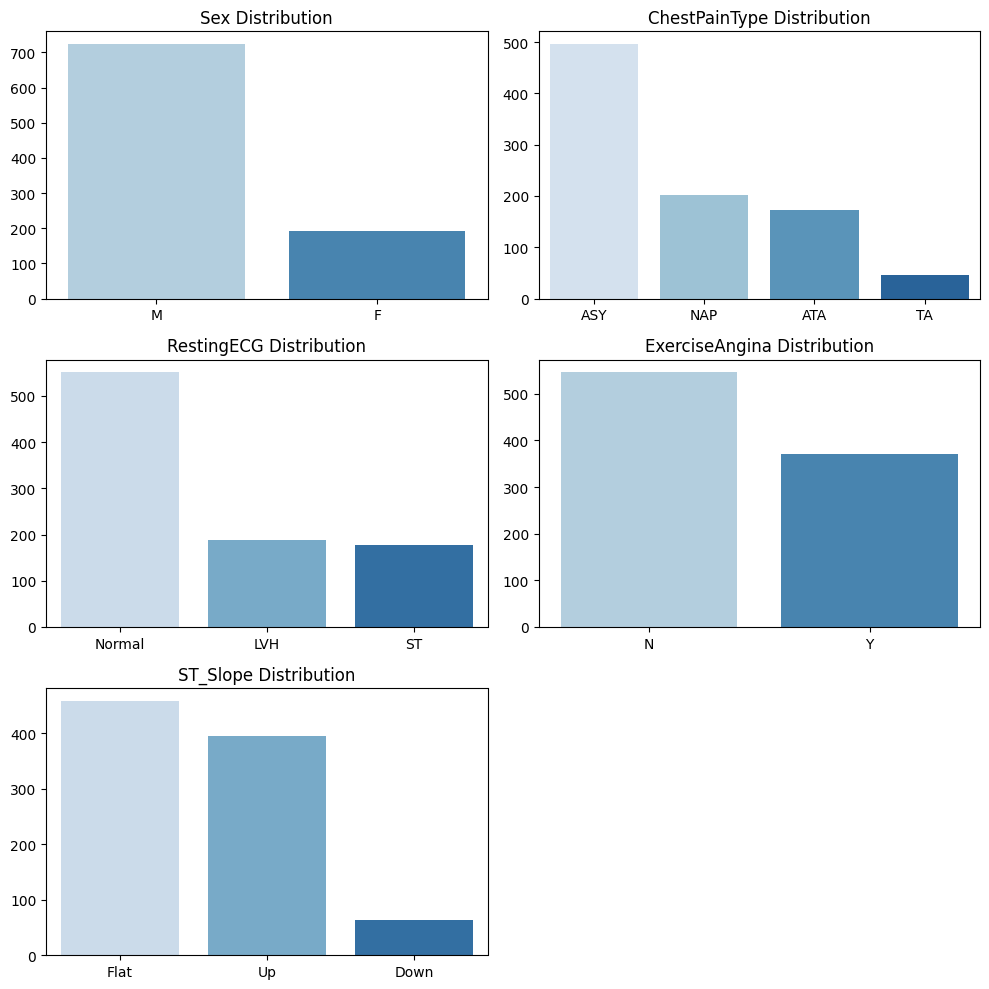

In [17]:
# Categorical distributions:

fig, axes = plt.subplots(3,2, figsize=(10,10))
axes = axes.flatten()

for i in range(len(cat_columns)):
    column_count = df[cat_columns[i]].value_counts()
    sns.barplot(x=column_count.index.values, y=column_count.values, palette='Blues', ax=axes[i])
    total = sum(column_count.values)
    percentages = []
    for amount in column_count.values:
        percentages.append(round(amount/total ,2))
    axes[i].set_title(f'{cat_columns[i]} Distribution')
        

plt.delaxes(ax=axes[5])
plt.tight_layout()
plt.show()

# There are a lot more samples of males than females. In terms of chest pain type, (according to 
# NICE clinical guideline) the prevalence of TA/ATA/NAP/ASY depends heavily on the setting of which 
# patients (where and in whom the data were collected).

In [18]:
# Prefer applying label encoder on columns with 2 unique values

two_values_columns = []
rest = []
for i in cat_columns:
    if len(df[i].unique()) == 2:
        two_values_columns.append(i)
    else:
        rest.append(i)

In [19]:
print(two_values_columns)
print(rest)

['Sex', 'ExerciseAngina']
['ChestPainType', 'RestingECG', 'ST_Slope']


In [20]:
df_encoded = df.copy()
le = LabelEncoder()
for i in two_values_columns:
    df_encoded[i] = le.fit_transform(df[i])

In [21]:
df_encoded = pd.get_dummies(df_encoded, columns=rest)

In [22]:
df_encoded *= 1
print('------')
print(f'encoded df shape: {df_encoded.shape}')
print('------')
df_encoded.head()

------
encoded df shape: (917, 19)
------


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,0,0,1,0,0,0,1,0,0,0,1
1,49,0,160,180,0,156,0,1.0,1,0,0,1,0,0,1,0,0,1,0
2,37,1,130,283,0,98,0,0.0,0,0,1,0,0,0,0,1,0,0,1
3,48,0,138,214,0,108,1,1.5,1,1,0,0,0,0,1,0,0,1,0
4,54,1,150,195,0,122,0,0.0,0,0,0,1,0,0,1,0,0,0,1


In [23]:
y = df_encoded[['HeartDisease']]
X = df_encoded.drop(columns=['HeartDisease'], axis=1)

# I opted to go for the robust scaler, which is less sensitive to outlires than the standard scaler.
# I think it makes more sense, since most cases are not going to be anomalies and our models 
# shouldn't be affected by them too much.

transformer = RobustScaler()
t = transformer.fit_transform(X)
X_robust = pd.DataFrame(t)

In [24]:
X_robust.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.076923,0.0,0.5,0.981132,0.0,0.944444,0.0,-0.400000,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
1,-0.384615,-1.0,1.5,-1.075472,0.0,0.500000,0.0,0.266667,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.307692,0.0,0.0,0.867925,0.0,-1.111111,0.0,-0.400000,-1.0,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,-1.0,1.0
3,-0.461538,-1.0,0.4,-0.433962,0.0,-0.833333,1.0,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,1.0,-0.792453,0.0,-0.444444,0.0,-0.400000,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0


In [25]:
X_train,X_test, y_train,y_test = train_test_split(X_robust, y, test_size=0.2)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [26]:
print('shapes:')
print(f'X train shape: {X_train.shape}, y train shape: {y_train.shape}')
print(f'X test shape: {X_test.shape}, y test shape: {y_test.shape}')
print('--------')

shapes:
X train shape: (733, 18), y train shape: (733, 1)
X test shape: (184, 18), y test shape: (184, 1)
--------


In [27]:
# The evaluation is going to be made with accuracy, accompanied for roc over auc scores to show
# how confident the model is.

def evaluate_model(model):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f'accuracy: {round(accuracy*100, 2):.2f}%')
    print(f'roc auc score: {round(roc_auc_score(y_test, y_pred) * 100, 2)}%')
    print(f'classification report: {classification_report(y_test, y_pred)}')

**PART 1**

In part 1 we are going to check non linear models such as:
Random Forest, XGBoost, Catboost, LightGBM, and Logistic Regression.

We are going to start with checking the models without tuning, and then with tuning.

We have around 86%-88% accuracy on these models, with around the same results for roc over auc.

In [28]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_classifier.fit(X_train, y_train)
evaluate_model(rf_classifier)

accuracy: 88.04%
roc auc score: 87.7%
classification report:               precision    recall  f1-score   support

           0       0.84      0.86      0.85        72
           1       0.91      0.89      0.90       112

    accuracy                           0.88       184
   macro avg       0.87      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



In [29]:
bst = XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic')
bst.fit(X_train,y_train)
evaluate_model(bst)

accuracy: 86.41%
roc auc score: 86.11%
classification report:               precision    recall  f1-score   support

           0       0.81      0.85      0.83        72
           1       0.90      0.88      0.89       112

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



In [30]:
cat_model = CatBoostClassifier(iterations=250, learning_rate=0.05, depth=6, verbose=0)
cat_model.fit(X_train,y_train)
evaluate_model(cat_model)

accuracy: 85.87%
roc auc score: 85.66%
classification report:               precision    recall  f1-score   support

           0       0.80      0.85      0.82        72
           1       0.90      0.87      0.88       112

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.86      0.86       184



In [31]:
lgb_model = lgb.LGBMClassifier(n_estimators=60,max_depth=5, object='binary', random_state=42, verbose=-1)
lgb_model.fit(X_train, y_train)
evaluate_model(lgb_model)

accuracy: 85.87%
roc auc score: 85.91%
classification report:               precision    recall  f1-score   support

           0       0.79      0.86      0.83        72
           1       0.91      0.86      0.88       112

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.86      0.86       184



In [32]:
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)
evaluate_model(logistic_reg)

accuracy: 86.41%
roc auc score: 86.86%
classification report:               precision    recall  f1-score   support

           0       0.79      0.89      0.84        72
           1       0.92      0.85      0.88       112

    accuracy                           0.86       184
   macro avg       0.86      0.87      0.86       184
weighted avg       0.87      0.86      0.87       184



In [33]:
def show_confusion_matrix(model):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [34]:
# The accuracy model is going to be used to check the choice of parameters, shouldn't be used
# to check the model's accuracy, that will be checked later, using the testing dataset, seperated
# from the training one.

def accuracy_model(model):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_robust, y, cv=cv, scoring='accuracy')
    scores_roc_auc = cross_val_score(model, X_robust, y, cv=cv, scoring='roc_auc')

    print(f'Accuracy per fold: {[round(n*100, 2) for n in scores]}')
    print(f'Mean accuracy: {round(scores.mean() * 100, 2)}%')

    print(f'roc auc score per fold: {[round(n*100, 2) for n in scores_roc_auc]}')
    print(f'Mean roc auc score: {round(scores_roc_auc.mean() * 100, 2)}%')

**Tuning**

Starting the tuning of the models, didn't prove to be that useful. The accuracy remained at around 
86%-88%, proving the default parameters to be the best ones in most cases, or very close to them.

In [35]:
param_grid_rf = {
    'classification__n_estimators':[90,100,110],
    'classification__criterion':['gini','entropy','log_loss'],
    'classification__max_depth':[5,6,7,8,9,10],
    'classification__min_samples_split':[5,10,15],
}

rfc = RandomForestClassifier(random_state=42)

pipeline = Pipeline([
    ('classification', rfc)
])

grid_search_rf = GridSearchCV(estimator=pipeline,param_grid=param_grid_rf, cv=StratifiedKFold(5), scoring='accuracy')

grid_search_rf.fit(X_train, y_train)

print("Best parameters found: ", grid_search_rf.best_params_)
print("Best cross-validation score: ", grid_search_rf.best_score_)

Best parameters found:  {'classification__criterion': 'gini', 'classification__max_depth': 5, 'classification__min_samples_split': 10, 'classification__n_estimators': 90}
Best cross-validation score:  0.8648681390364364


--------

Accuracy per fold: [89.67, 87.5, 84.15, 89.07, 80.87]
Mean accuracy: 86.25%
roc auc score per fold: [93.95, 94.13, 90.41, 94.72, 90.32]
Mean roc auc score: 92.71%
--------

accuracy: 85.33%
roc auc score: 85.22%
classification report:               precision    recall  f1-score   support

           0       0.79      0.85      0.82        72
           1       0.90      0.86      0.88       112

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.85       184
weighted avg       0.86      0.85      0.85       184

--------



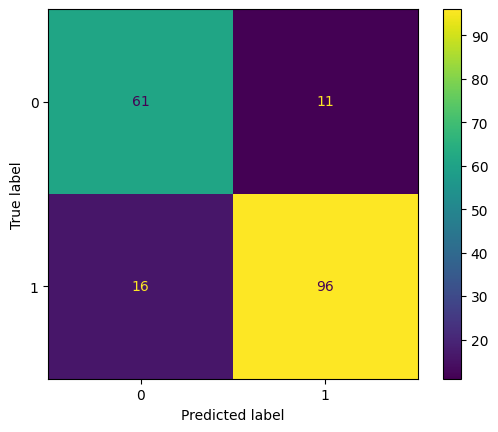

In [36]:
best_rfc = grid_search_rf.best_estimator_
best_rfc.set_params(classification__random_state=42)
best_rfc.fit(X_train, y_train)

print('--------\n')
accuracy_model(best_rfc)
print('--------\n')
evaluate_model(best_rfc)
print('--------\n')
show_confusion_matrix(best_rfc)

In [37]:
param_grid_xgboost = {
    'classification__max_depth': [2,3,4,5,6,7],
    'classification__eta': [0.4,0.5,0.6,0.7,0.8],
    'classification__gamma': [2, 5],
    'classification__max_delta_step': [1, 2, 3],
    'classification__lambda': [1, 2, 3]
}

bst_grid_search = XGBClassifier(class_weight='balanced', objective='binary:logistic')

pipeline_xgboost = Pipeline([
    ('classification', bst_grid_search)
])

grid_search_xgboost = GridSearchCV(estimator=pipeline_xgboost,param_grid=param_grid_xgboost, cv=StratifiedKFold(5), scoring='accuracy')

grid_search_xgboost.fit(X_train, y_train)

print("Best parameters found: ", grid_search_xgboost.best_params_)
print("Best cross-validation score: ", grid_search_xgboost.best_score_)

Best parameters found:  {'classification__eta': 0.7, 'classification__gamma': 2, 'classification__lambda': 2, 'classification__max_delta_step': 2, 'classification__max_depth': 3}
Best cross-validation score:  0.8703196347031963


--------

Accuracy per fold: [90.22, 86.96, 83.61, 87.43, 81.42]
Mean accuracy: 85.93%
roc auc score per fold: [93.78, 93.69, 88.34, 94.81, 91.11]
Mean roc auc score: 92.35%
--------

accuracy: 87.50%
roc auc score: 86.51%
classification report:               precision    recall  f1-score   support

           0       0.86      0.82      0.84        72
           1       0.89      0.91      0.90       112

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184

--------



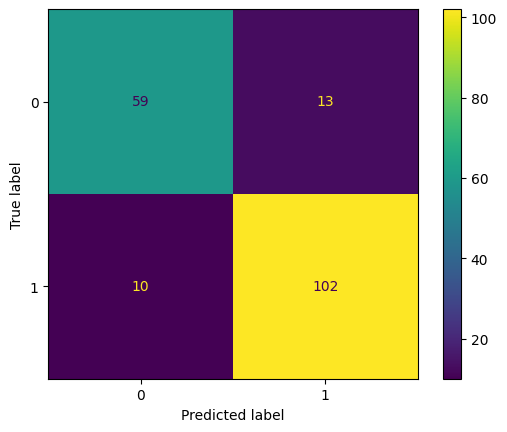

In [38]:
best_xgboost = grid_search_xgboost.best_estimator_
best_xgboost.set_params(classification__random_state=42)
best_xgboost.fit(X_train, y_train)

print('--------\n')
accuracy_model(best_xgboost)
print('--------\n')
evaluate_model(best_xgboost)
print('--------\n')
show_confusion_matrix(best_xgboost)

In [39]:
param_grid_catboost = {
    'classification__learning_rate': [0.6,0.7,0.8],
    'classification__depth': [4,5,6,7],
    'classification__iterations': [25,30,35,40,45],
    'classification__random_strength': [1.1, 1.2,1.3,1.4,1.5],
    'classification__grow_policy': ['SymetricTree', 'Depthwise'],
    
}

catboost_grid_search = CatBoostClassifier(verbose=0, random_seed=42)

pipeline_catboost = Pipeline([
    ('classification', catboost_grid_search)
])

grid_search_catboost = GridSearchCV(estimator=pipeline_catboost,param_grid=param_grid_catboost, cv=StratifiedKFold(5), scoring='accuracy')

grid_search_catboost.fit(X_train, y_train)

print("Best parameters found: ", grid_search_catboost.best_params_)
print("Best cross-validation score: ", grid_search_catboost.best_score_)

Best parameters found:  {'classification__depth': 4, 'classification__grow_policy': 'Depthwise', 'classification__iterations': 25, 'classification__learning_rate': 0.6, 'classification__random_strength': 1.5}
Best cross-validation score:  0.8703289534992079


--------

Accuracy per fold: [90.22, 86.96, 85.79, 87.43, 84.15]
Mean accuracy: 86.91%
roc auc score per fold: [92.84, 93.27, 89.66, 93.87, 91.61]
Mean roc auc score: 92.25%
--------

accuracy: 86.96%
roc auc score: 86.56%
classification report:               precision    recall  f1-score   support

           0       0.82      0.85      0.84        72
           1       0.90      0.88      0.89       112

    accuracy                           0.87       184
   macro avg       0.86      0.87      0.86       184
weighted avg       0.87      0.87      0.87       184

--------



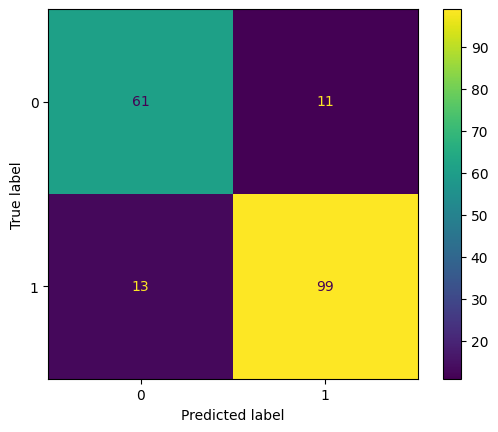

In [40]:
best_catboost = grid_search_catboost.best_estimator_
best_catboost.fit(X_train, y_train)

print('--------\n')
accuracy_model(best_catboost)
print('--------\n')
evaluate_model(best_catboost)
print('--------\n')
show_confusion_matrix(best_catboost)

In [41]:
param_grid_lgb = {
    'classification__max_depth': [-1, 6, 7, 8],
    'classification__learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'classification__n_estimators': [50, 60, 70, 80],
    'classification__class_weight': [None, 'balanced'],
    'classification__min_child_samples': [30, 35, 40, 45],
}

lgb_grid_search = lgb.LGBMClassifier(random_state=42, verbose=-1)

pipeline_lgb = Pipeline([
    ('classification', lgb_grid_search)
])

grid_search_lgb = GridSearchCV(estimator=pipeline_lgb,param_grid=param_grid_lgb, cv=StratifiedKFold(5), scoring='accuracy', verbose=0)

grid_search_lgb.fit(X_train, y_train)

print("Best parameters found: ", grid_search_lgb.best_params_)
print("Best cross-validation score: ", grid_search_lgb.best_score_)

Best parameters found:  {'classification__class_weight': None, 'classification__learning_rate': 0.05, 'classification__max_depth': 7, 'classification__min_child_samples': 35, 'classification__n_estimators': 70}
Best cross-validation score:  0.8676171838598453


--------

Accuracy per fold: [89.13, 89.13, 84.7, 89.07, 83.06]
Mean accuracy: 87.02%
roc auc score per fold: [94.14, 93.96, 89.71, 95.31, 91.49]
Mean roc auc score: 92.92%
--------

accuracy: 88.04%
roc auc score: 87.45%
classification report:               precision    recall  f1-score   support

           0       0.85      0.85      0.85        72
           1       0.90      0.90      0.90       112

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184

--------



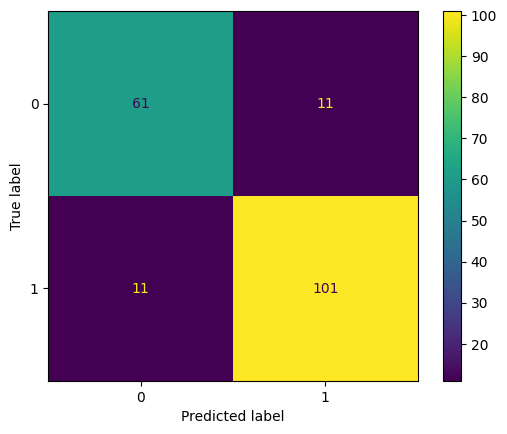

In [42]:
best_lgb = grid_search_lgb.best_estimator_
best_lgb.set_params(classification__random_state=42)
best_lgb.fit(X_train, y_train)

print('--------\n')
accuracy_model(best_lgb)
print('--------\n')
evaluate_model(best_lgb)
print('--------\n')
show_confusion_matrix(best_lgb)

In [43]:
param_grid_logistic_regression = {
    'classification__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'classification__class_weight': [None, 'balanced'],
    'classification__solver': ['lbfgs', 'newton-cg', 'saga'],
    'classification__max_iter': [50,60,70, 80, 85, 90],
    'classification__warm_start': [False, True]
}

logistic_reg_grid_search = LogisticRegression(random_state=42)

pipeline_logistic_regression = Pipeline([
    ('classification', logistic_reg_grid_search)
])

grid_search_logistic_regression = GridSearchCV(estimator=pipeline_logistic_regression,param_grid=param_grid_logistic_regression, cv=StratifiedKFold(5), scoring='accuracy')

grid_search_logistic_regression.fit(X_train, y_train)

print("Best parameters found: ", grid_search_logistic_regression.best_params_)
print("Best cross-validation score: ", grid_search_logistic_regression.best_score_)

Best parameters found:  {'classification__class_weight': None, 'classification__max_iter': 50, 'classification__penalty': 'l2', 'classification__solver': 'lbfgs', 'classification__warm_start': False}
Best cross-validation score:  0.8621190942130277


--------

Accuracy per fold: [86.96, 86.96, 84.15, 87.98, 85.25]
Mean accuracy: 86.26%
roc auc score per fold: [93.01, 93.42, 91.04, 93.43, 89.41]
Mean roc auc score: 92.06%
--------

accuracy: 86.41%
roc auc score: 86.86%
classification report:               precision    recall  f1-score   support

           0       0.79      0.89      0.84        72
           1       0.92      0.85      0.88       112

    accuracy                           0.86       184
   macro avg       0.86      0.87      0.86       184
weighted avg       0.87      0.86      0.87       184

--------



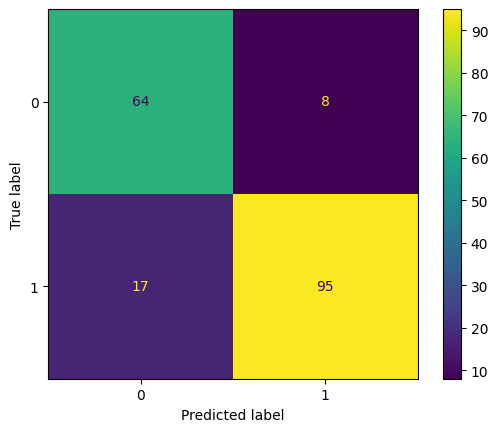

In [44]:
best_logistic_regression = grid_search_logistic_regression.best_estimator_
best_logistic_regression.set_params(classification__random_state=42)
best_logistic_regression.fit(X_train, y_train)
print('--------\n')
accuracy_model(best_logistic_regression)
print('--------\n')
evaluate_model(best_logistic_regression)
print('--------\n')
show_confusion_matrix(best_logistic_regression)

**PART 2**

NEURAL NETWORK

After looking at the non linear models from part 1, we are going to see if it's possible to get 
better accuracy using a neural network, the results from part 1 in terms of accuracy were 86%-88%.

The Neural network is going to give us around 84% accuracy on average, after testing multiple times.

In [45]:
EPOCHS = 50
BATCH_SIZE=64

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=0, min_lr= 0.0000001)
model_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(18, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_nn.compile(optimizer='Adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy']
                )
model_nn.fit(X_train, y_train, verbose=0,validation_split=0.2, callbacks=[lr_schedule], epochs=EPOCHS, batch_size=BATCH_SIZE)

2025-10-15 11:02:39.683224: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-10-15 11:02:39.874663: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


In [46]:
model_nn.evaluate(X_test, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8552 - loss: 0.3693 


2025-10-15 11:02:48.483336: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[0.3734520971775055, 0.842391312122345]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
accuracy: 0.84
roc auc score: 84.33%
classification report:               precision    recall  f1-score   support

           0       0.77      0.85      0.81        72
           1       0.90      0.84      0.87       112

    accuracy                           0.84       184
   macro avg       0.83      0.84      0.84       184
weighted avg       0.85      0.84      0.84       184



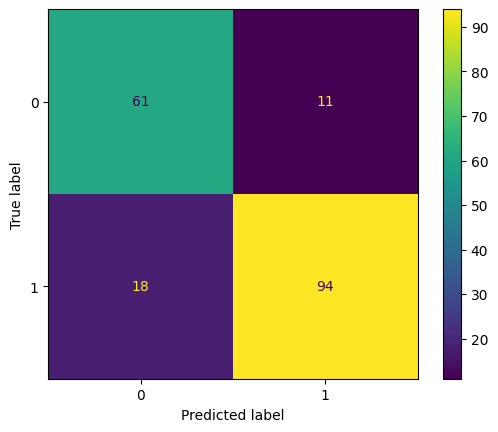

In [47]:
y_pred_nn = model_nn.predict(X_test)
y_pred_nn = (y_pred_nn > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_nn)
    
print(f'accuracy: {accuracy:.2f}')
print(f'roc auc score: {round(roc_auc_score(y_test, y_pred_nn) * 100, 2)}%')
print(f'classification report: {classification_report(y_test, y_pred_nn)}')

cm = confusion_matrix(y_test, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Seems like the neural network was not able to perform better than the other models, staying 
at around 84% accuracy. Might be a problem with the architecture, further testing should
bring better results. 

**Conclusions:**

It seems like the non linear models at part 1 got the best results, hovering at around 87%, with some
with 88% accuracy, after tuning. 
The neural network model seems to be at around 84% accuracy, with
architecture that can be improved and tuned to get better results.

I would use XGBoost or Random Forest as a model for predicting, considering the fact
that they get the highest accuracy at around 88% more consistantly than others. However I didn't
take into account the fact that it makes a lot more sense for the models to be more leaning towards
determining that a person has a heart problem, with the help of a doctor that can be a useful
model for filtering the people that based on the data, are more obvious to not have heart problems.

I learned a lot about tuning in this project, I really enjoyed tuning the non linear models in part 1
and the nn in part 2, it was really interesting. I wanted to use SMORE and NearMiss here too, but 
because of an import error, it's going to be something that stays for more advanced projects.

I think that by removing some of the outliers in some of the features which are highly correlated
with the class, the model's accuracy can be improved, this is something that is going to be explored
in futher projects since I think it's a little more advanced. I hoped you enjoyed my project, it was 
more focused on the models than the data analysis, but it's still pretty good at this level.